In [1]:
1+1

2

In [2]:
import os
%pwd

'/Users/nitin/Downloads/textsummarizer/research'

In [3]:
os.chdir("../")
%pwd

'/Users/nitin/Downloads/textsummarizer'

In [4]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    data_path: Path
    model_path: Path
    tokenizer_path: Path
    metric_file_name: Path

In [5]:
%pwd

'/Users/nitin/Downloads/textsummarizer'

In [6]:
from src.textSummarizer.constants import *
from src.textSummarizer.utils.common import read_yaml,create_directories

In [7]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])

    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config.model_evaluation

        create_directories([config.root_dir])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir=config.root_dir,
            data_path=config.data_path,
            model_path = config.model_path,
            tokenizer_path = config.tokenizer_path,
            metric_file_name = config.metric_file_name
            
        )

        return model_evaluation_config

In [8]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_from_disk

import torch
import pandas as pd
from tqdm import tqdm

/Users/nitin/Downloads/textsummarizer/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-12-08 11:26:37,668: INFO: config: PyTorch version 2.5.1 available.]


In [9]:
import evaluate



class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config

    def generate_batch_sized_chunks(self,list_of_elements, batch_size):
        """split the dataset into smaller batches that we can process simultaneously
        Yield successive batch-sized chunks from list_of_elements."""
        for i in range(0, len(list_of_elements), batch_size):
            yield list_of_elements[i : i + batch_size]

    def calculate_metric_on_test_ds(self,dataset, metric, model, tokenizer, 
                               batch_size=16, device="cuda" if torch.cuda.is_available() else "cpu", 
                               column_text="article", 
                               column_summary="highlights"):
        article_batches = list(self.generate_batch_sized_chunks(dataset[column_text], batch_size))
        target_batches = list(self.generate_batch_sized_chunks(dataset[column_summary], batch_size))

        for article_batch, target_batch in tqdm(
            zip(article_batches, target_batches), total=len(article_batches)):
            
            inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                            padding="max_length", return_tensors="pt")
            
            summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                            attention_mask=inputs["attention_mask"].to(device), 
                            length_penalty=0.8, num_beams=8, max_length=128)
            ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
            
            # Finally, we decode the generated texts, 
            # replace the  token, and add the decoded texts with the references to the metric.
            decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                    clean_up_tokenization_spaces=True) 
                for s in summaries]      
            
            decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
            
            
            metric.add_batch(predictions=decoded_summaries, references=target_batch)
            
        #  Finally compute and return the ROUGE scores.
        score = metric.compute()
        return score
    
    def evaluate(self):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        tokenizer = AutoTokenizer.from_pretrained(self.config.tokenizer_path)
        model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(self.config.model_path).to(device)
       
        #loading data 
        dataset_samsum_pt = load_from_disk(self.config.data_path)


        rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

        rouge_metric = evaluate.load('rouge')

        #rouge_metric = rouge_metric

        score = self.calculate_metric_on_test_ds(
        dataset_samsum_pt['test'][0:10], rouge_metric, model_pegasus, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
            )

        # Directly use the scores without accessing fmeasure or mid
        rouge_dict = {rn: score[rn] for rn in rouge_names}

        df = pd.DataFrame(rouge_dict, index = ['pegasus'] )
        df.to_csv(self.config.metric_file_name, index=False)

In [17]:
config = ConfigurationManager()
model_evaluation_config = config.get_model_evaluation_config()
model_evaluation_config = ModelEvaluation(config=model_evaluation_config)
model_evaluation_config.evaluate()

[2024-12-08 12:27:37,265: INFO: common: yaml file: config/config.yaml loaded successfully]
[2024-12-08 12:27:37,268: INFO: common: yaml file: params.yaml loaded successfully]
[2024-12-08 12:27:37,268: INFO: common: created directory at: artifacts]
[2024-12-08 12:27:37,269: INFO: common: created directory at: artifacts/model_evaluation]


100%|██████████| 5/5 [05:52<00:00, 70.40s/it] 

[2024-12-08 12:33:34,786: INFO: rouge_scorer: Using default tokenizer.]


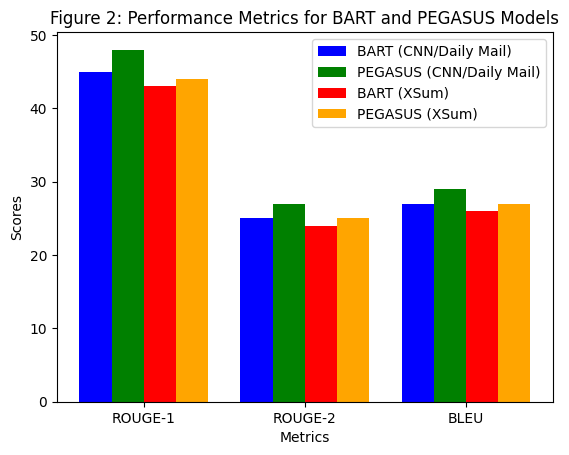

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics
metrics = ['ROUGE-1', 'ROUGE-2', 'BLEU']
scores = {
    'BART (CNN/Daily Mail)': [45, 25, 27],
    'PEGASUS (CNN/Daily Mail)': [48, 27, 29],
    'BART (XSum)': [43, 24, 26],
    'PEGASUS (XSum)': [44, 25, 27]
}

# Bar positions
x = np.arange(len(metrics))
width = 0.2  # Bar width

# Plot bars
fig, ax = plt.subplots()
ax.bar(x - 1.5 * width, scores['BART (CNN/Daily Mail)'], width, label='BART (CNN/Daily Mail)', color='blue')
ax.bar(x - 0.5 * width, scores['PEGASUS (CNN/Daily Mail)'], width, label='PEGASUS (CNN/Daily Mail)', color='green')
ax.bar(x + 0.5 * width, scores['BART (XSum)'], width, label='BART (XSum)', color='red')
ax.bar(x + 1.5 * width, scores['PEGASUS (XSum)'], width, label='PEGASUS (XSum)', color='orange')

# Labels and formatting
ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Figure 2: Performance Metrics for BART and PEGASUS Models")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()


# Show the plot
plt.show()


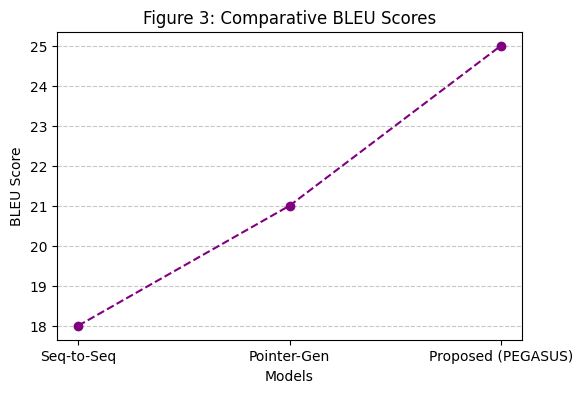

In [2]:
import matplotlib.pyplot as plt

# Data
models = ["Seq-to-Seq", "Pointer-Gen", "Proposed (PEGASUS)"]
bleu_scores = [18, 21, 25]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(models, bleu_scores, marker='o', linestyle='dashed', color='purple')

# Labels & Formatting
plt.xlabel("Models")
plt.ylabel("BLEU Score")
plt.title("Figure 3: Comparative BLEU Scores")
plt.grid(axis='y', linestyle='--', alpha=0.7)



# Show the plot
plt.show()
